# Point Cloud-to-Simplicial Complex Lifting Tutorial
This notebook shows how to construct a simplicial complex from a point cloud using witness lifting. This lifting constructs a simplicial complex from a point cloud, called the **Witness complex**.

In [2]:
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import PointCloudLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_transform_config,
)

In [3]:
loader = PointCloudLoader(
    {
        "data_dir": "modules/transforms/liftings/pointcloud2simplicial/",
    }
)

dataset = loader.load()

Processing...
Done!


In [4]:
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "pointcloud2simplicial/witness_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for pointcloud2simplicial/witness_lifting:

{'transform_type': 'lifting',
 'transform_name': 'WitnessLifting',
 'feature_lifting': 'ProjectionSum'}


Processing...
Done!



Dataset only contains 1 sample:


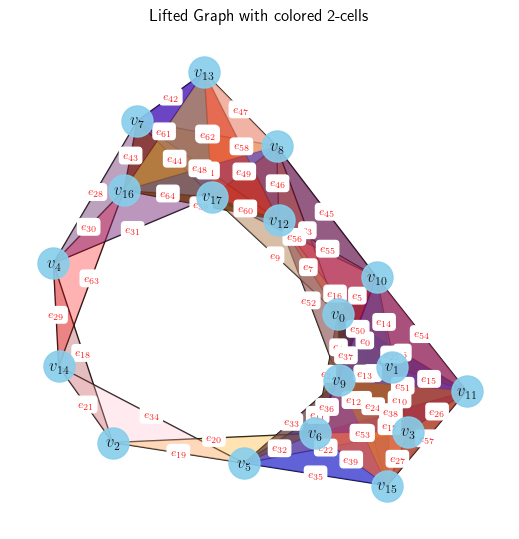

 - The complex has 18 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 65 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 101 2-cells.
 - The 2-cells have features dimension 1



In [5]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)